In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

In [2]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [5]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()

In [118]:
def get_pred (y_train, y_pred):
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30
    
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    return pred

In [148]:
def show_pred (pred, states=SIGLAS):
    
    for state in states:
        
        fig, ax = plt.subplots()

        pred[pred['estados'] == state].plot(y="y_pred", ax=ax, figsize=(12,6), color="coral", title=f"Previsão x Dado Real: {state}", ylabel="Consumo")
        pred[pred['estados'] == state].plot(y="y_test", linestyle=' ', marker="o", ax=ax)

    plt.show()

# SEED

In [130]:
SEED = 41

os.environ['PYTHONHASHSEED'] = str(SEED)
set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [131]:
STATES = ['SP', 'RS','AL','DF']

# Dados

In [6]:
df = pd.read_csv(f"{PATH}processado.csv")

In [7]:
x  = df.copy()
x = x.sort_values(["data", "estados"])
x = x.drop(["consumo", 'data'], axis=1)

y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]

In [8]:
# processo de one-hot
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

y = y['consumo']

In [199]:
def load_data():
    
    df = pd.read_csv(f"{PATH}processado.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Regressão Linear


## Tradicional

In [10]:
x,y = load_data()

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.9009930101570905


In [15]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 56315.70543358106
MAE: 36748.473266270536
MAPE: 0.7518614807352578


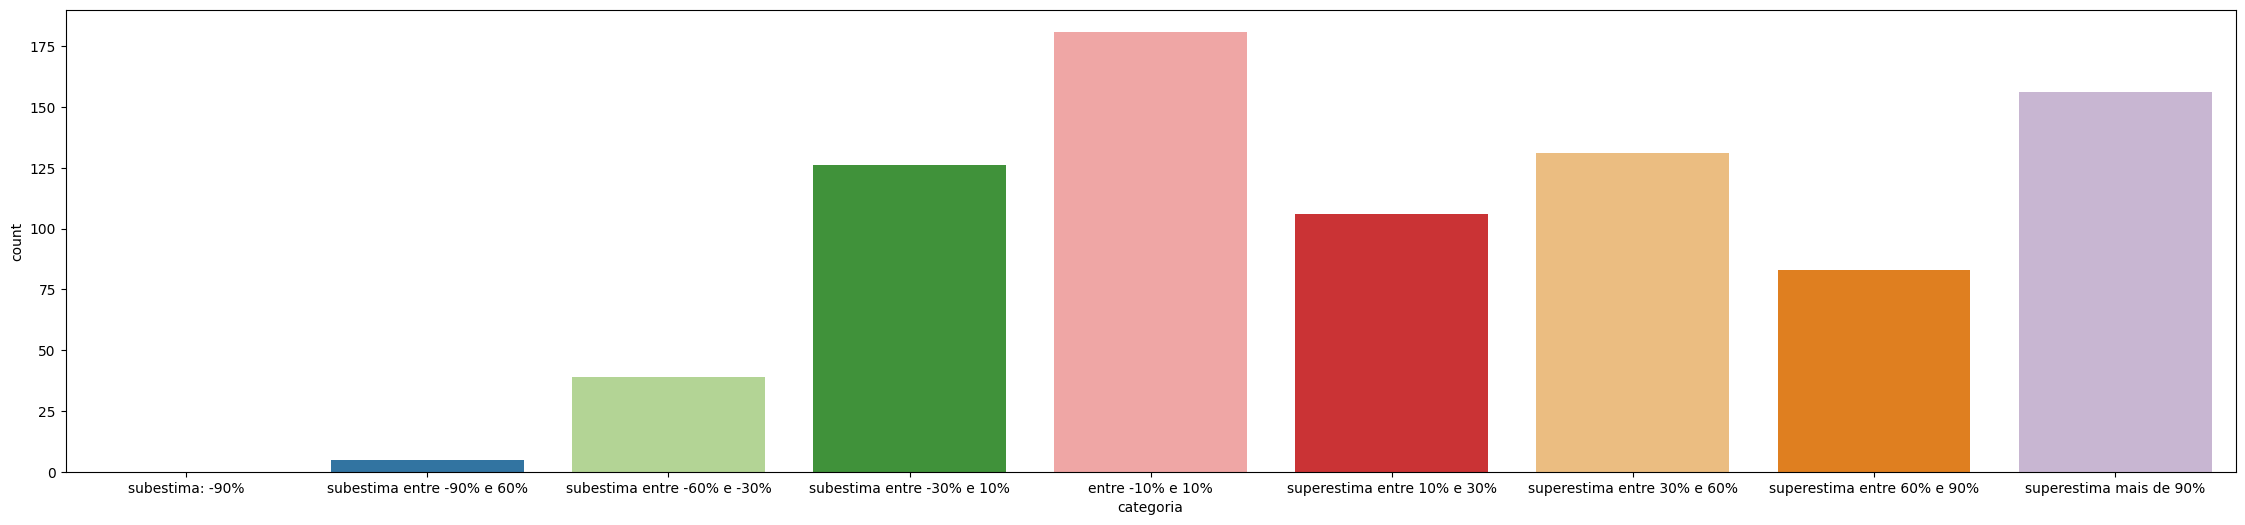

In [13]:
show_delta(np.array(y_test), y_pred.flatten())

## Tirando algumas variáveis

In [16]:
x,y = load_data()
DROP=['pib_pc', 'incc','igp', 'selic', 'idh_e', 'idh_l', 'estoque']
x=x.drop(DROP, axis=1)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

Score: 0.9465283365851807


In [18]:
# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 41386.47591828488
MAE: 26636.714651598526
MAPE: 0.3189378258336354


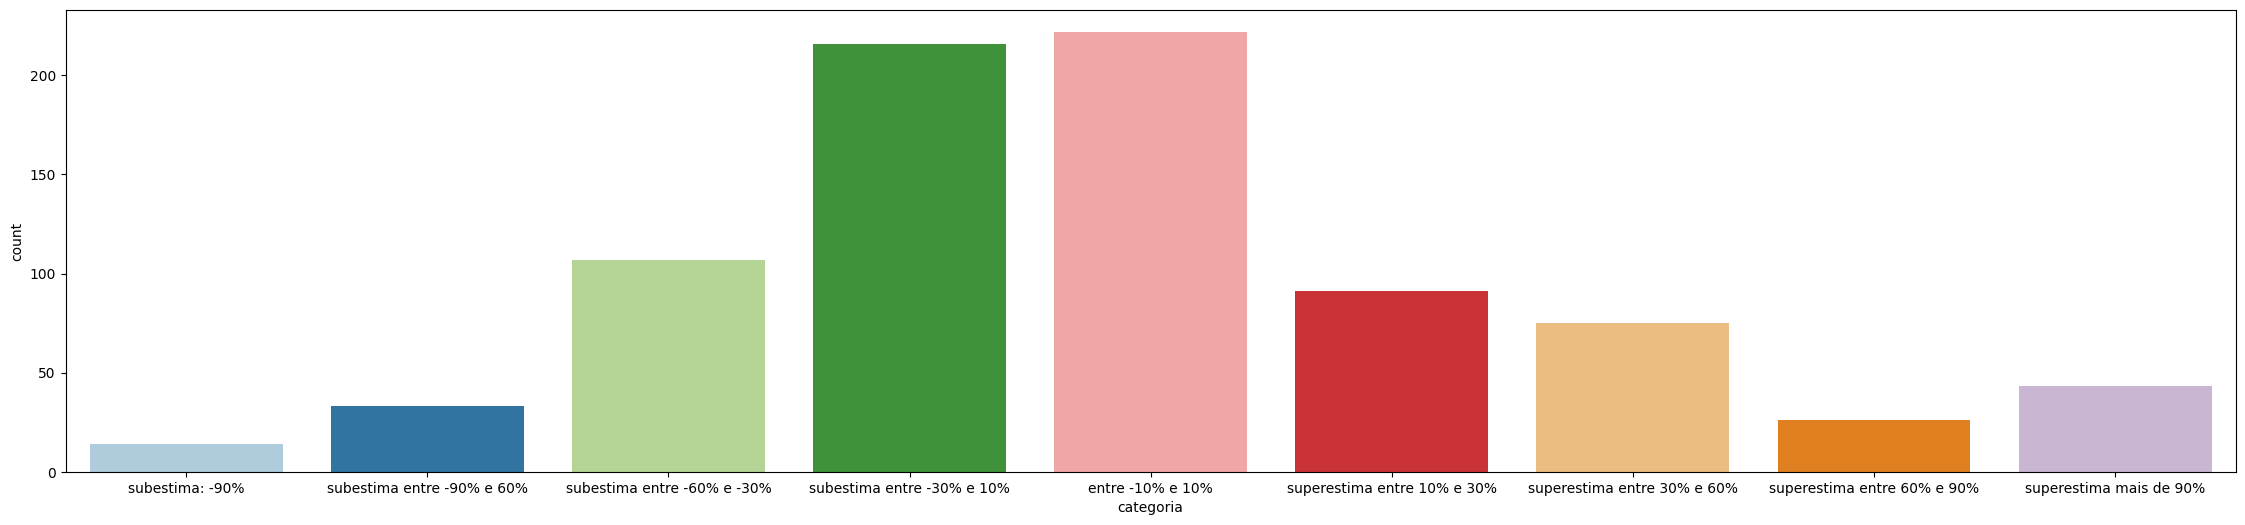

In [19]:
show_delta(np.array(y_test), y_pred.flatten())

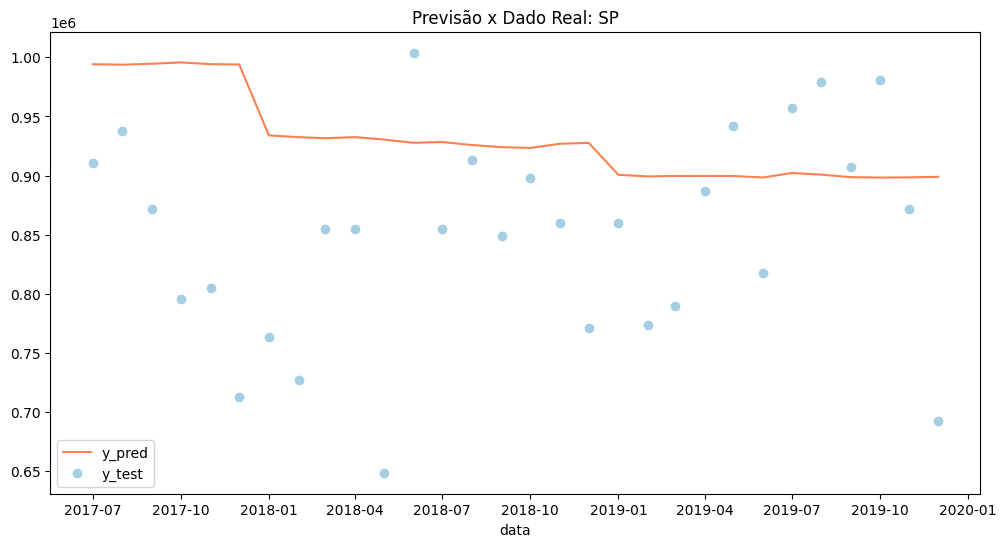

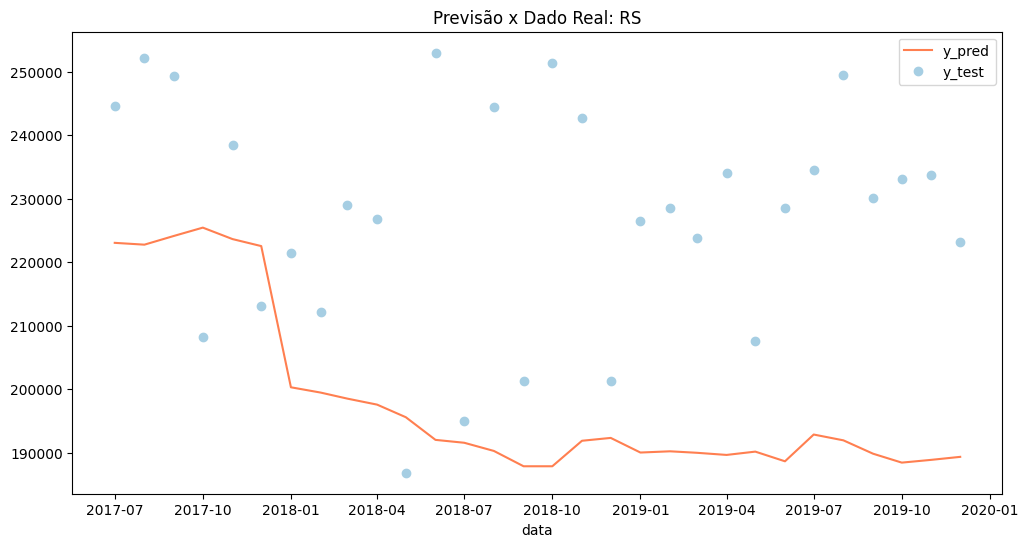

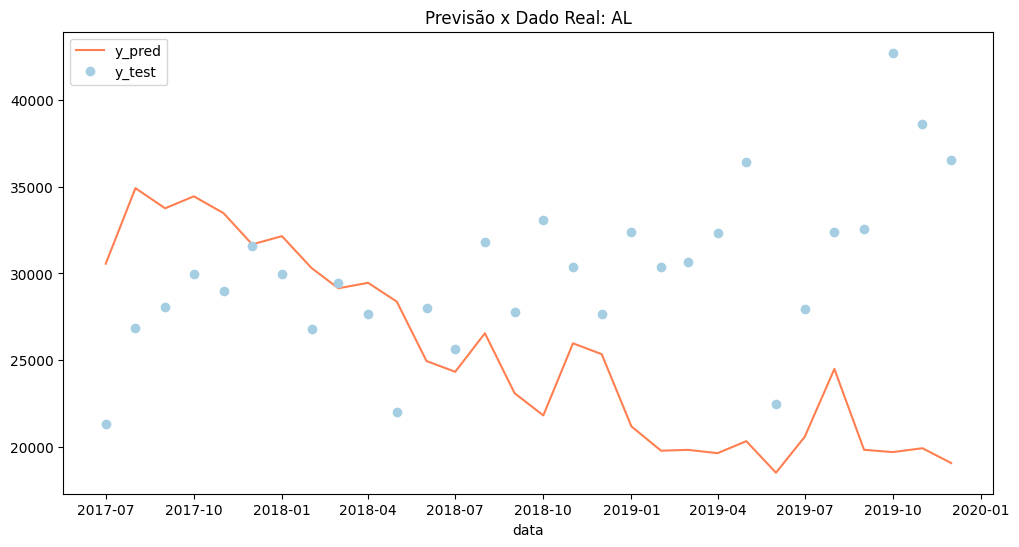

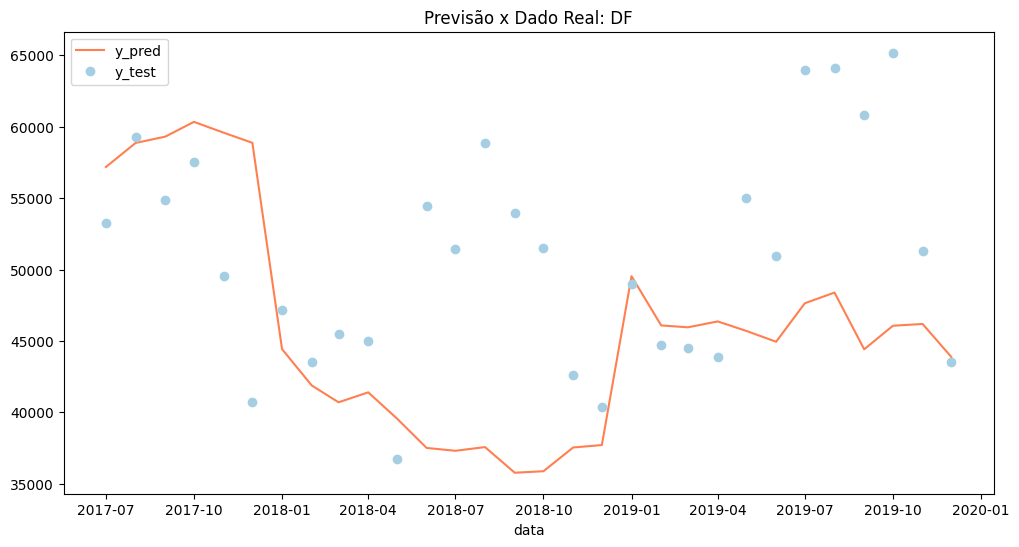

In [132]:
pred = get_pred(y_test, y_pred)
show_pred(pred, STATES)

# Redes MLP

In [133]:
x,y = load_data()

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

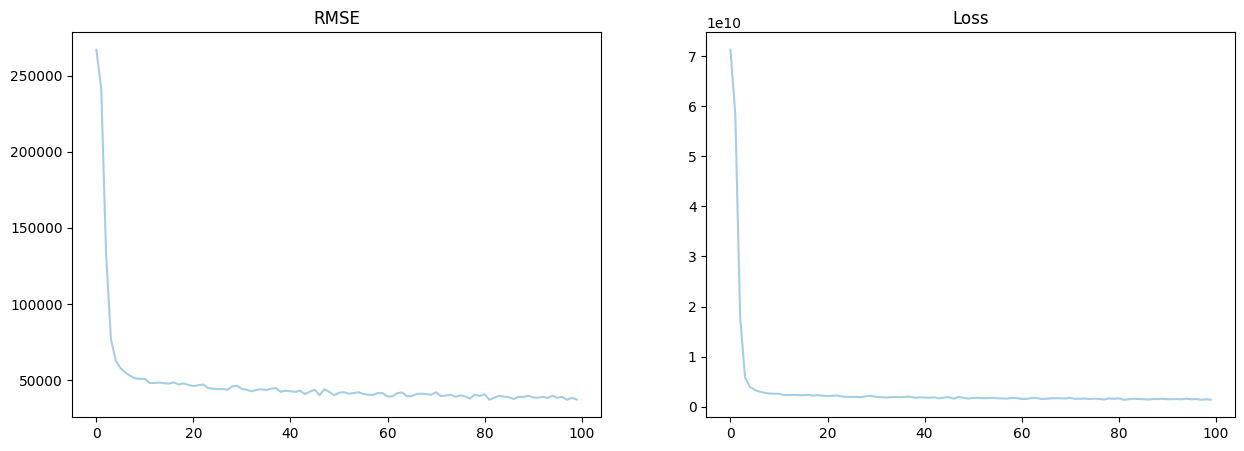

In [135]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [136]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 43474.82245878931
MAE: 30190.870482069982
MAPE: 0.5779640279651234


In [138]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=400, verbose=0)

In [139]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 47581.34780259449
MAE: 30327.51206591974
MAPE: 0.5571501519040004


In [140]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose = 0)

In [141]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 44877.45291405714
MAE: 29918.494230369557
MAPE: 0.47987130846465176


In [142]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

In [143]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 38458.5273706005
MAE: 24103.09270465302
MAPE: 0.2607347113822952


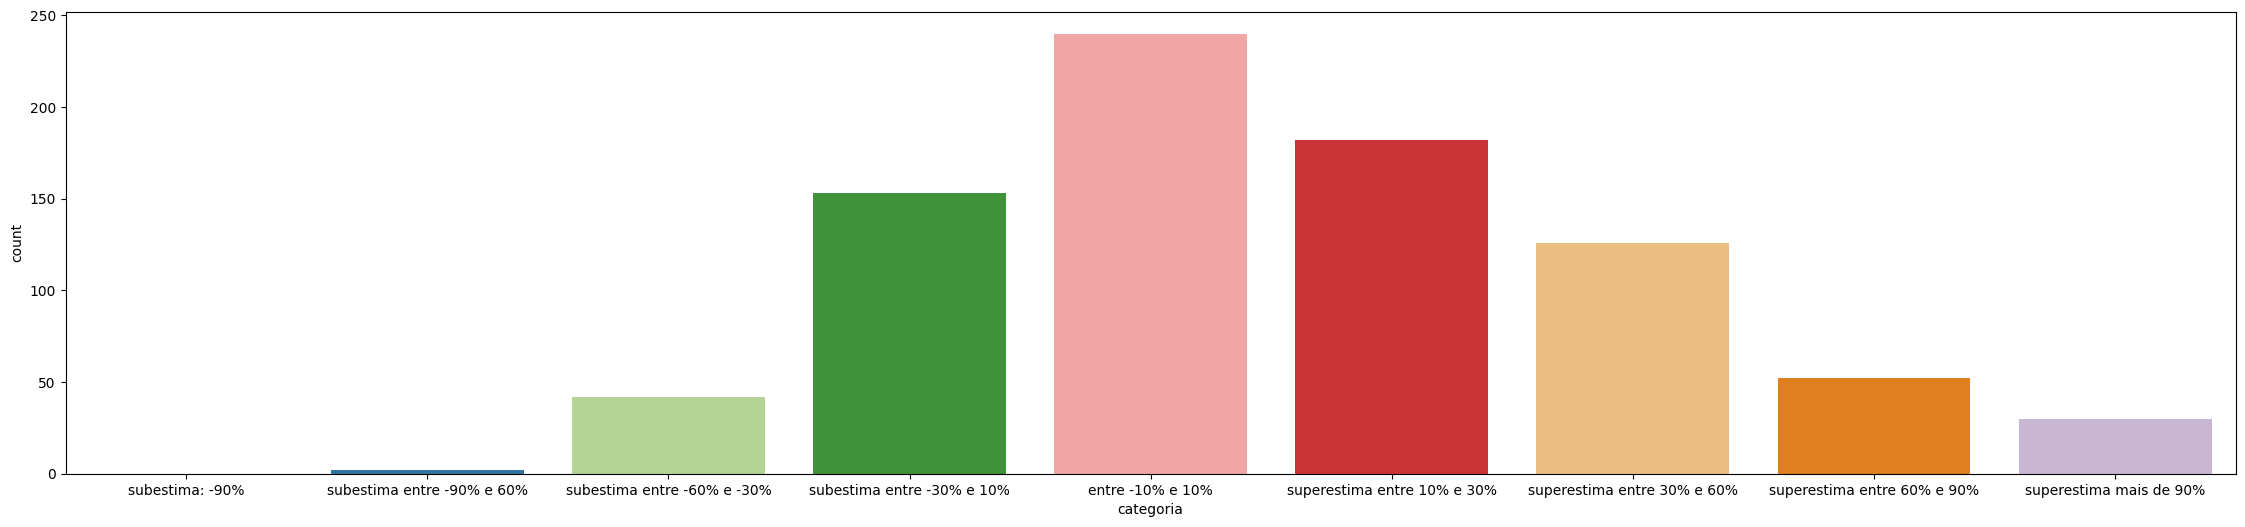

In [144]:
show_delta(np.array(y_test), y_pred.flatten())

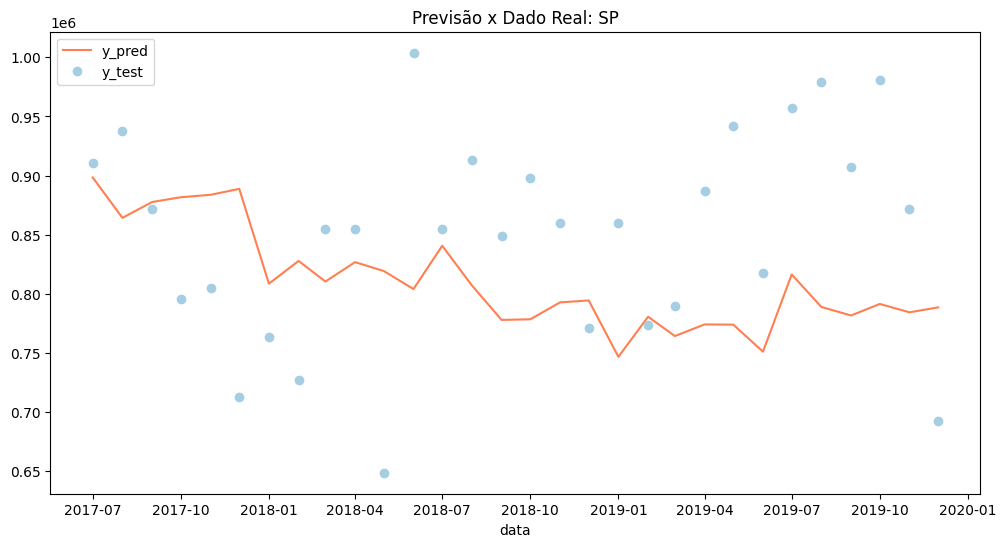

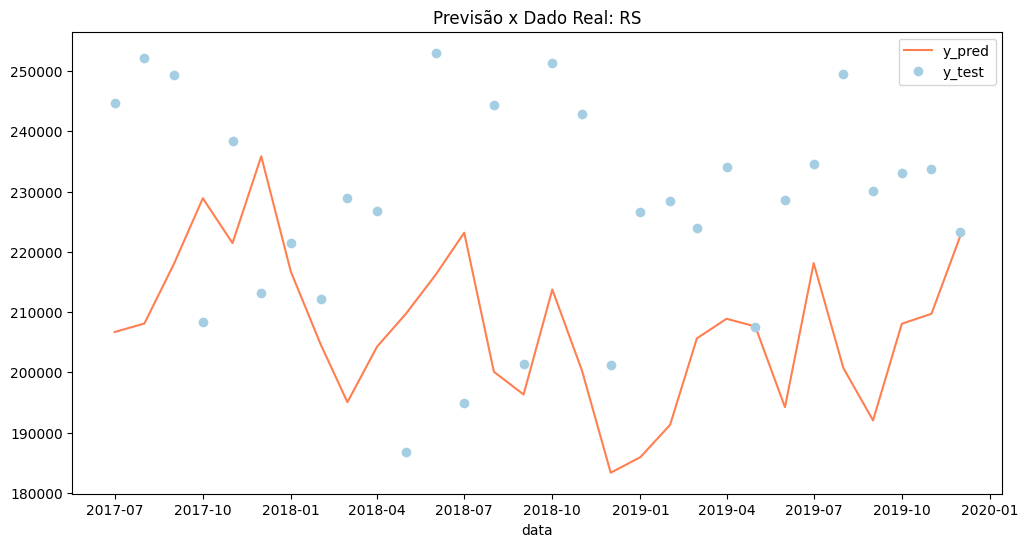

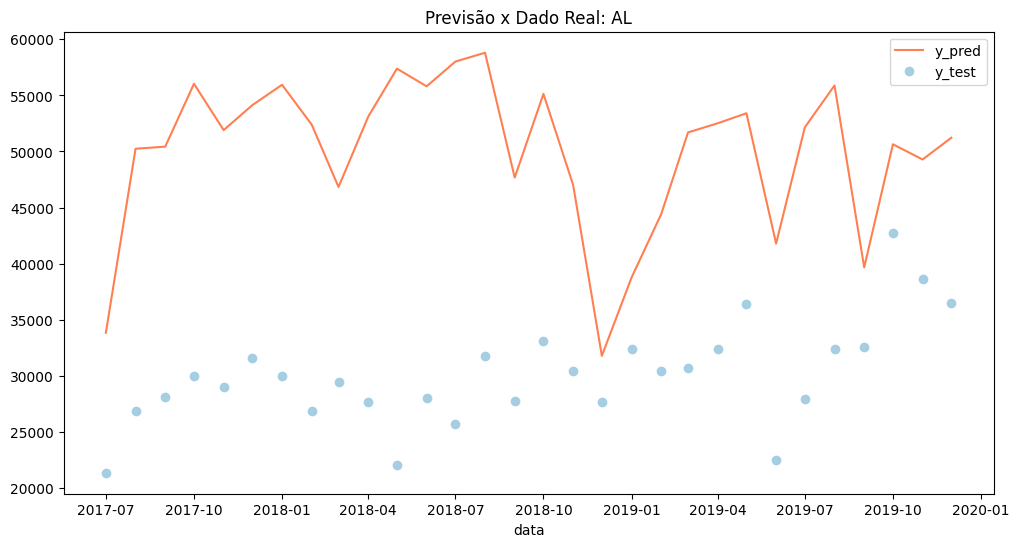

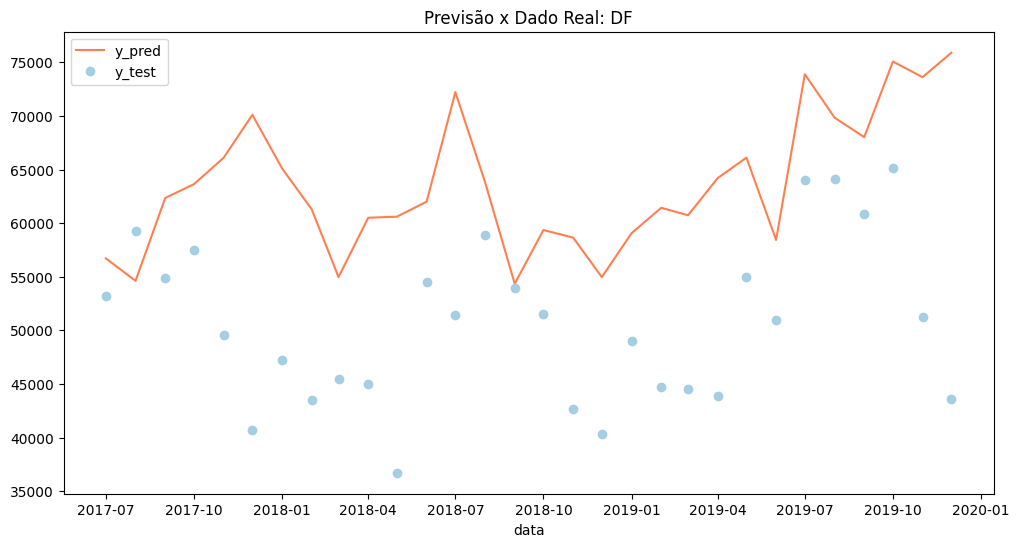

In [145]:
pred = get_pred(y_test, y_pred)
show_pred(pred, STATES)

In [151]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=500, verbose=0)

In [152]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 54126.31699324455
MAE: 32195.347670420193
MAPE: 0.3856573728588762


In [90]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 43617.819829038555
MAE: 28188.95940416698
MAPE: 0.32796647506510546


In [153]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=150, verbose=0)

In [154]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 43449.54684206569
MAE: 28552.598598567867
MAPE: 0.4004041175600771


# LSTM

In [207]:
class Scaler3DShape:
    
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() 

    def fit_transform(self, x):
        x_new = self.scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

    def transform(self, x):
        x_new = self.scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

In [191]:
def split_sequences(seq, size):
    
    lis = []
    
    for ini in range(len(seq)):
        
        end = ini + size
        
        if end > len(seq):
            break
            
            
        lis += [seq[ini:end]]
        
    return np.array(lis)

In [167]:
# n_steps -> timestep no tempo .. pegar contexto
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [200]:
x,y = load_data()

In [172]:
timestamp=3

In [ ]:
x,y = load_data()

timestamp=3

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestamp)
x_test = split_sequences(x_test.values, timestamp)
y_train = y_train[:-timestamp+1]
y_test = y_test[:-timestamp+1]

scaler = Scaler3DShape()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [223]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

In [224]:
x_train = split_sequences(x_train.values, timestamp)
x_test = split_sequences(x_test.values, timestamp)
y_train = y_train[:-timestamp+1]
y_test = y_test[:-timestamp+1]

In [225]:
scaler = Scaler3DShape()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [230]:
model = Sequential()
model.add(LSTM(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
147/147 [==============================] - 5s 5ms/step - loss: 71543267328.0000 - RMSE: 267475.7188
Epoch 2/100
147/147 [==============================] - 1s 5ms/step - loss: 42037362688.0000 - RMSE: 205030.1562
Epoch 3/100
147/147 [==============================] - 1s 7ms/step - loss: 6628136448.0000 - RMSE: 81413.3672
Epoch 4/100
147/147 [==============================] - 1s 7ms/step - loss: 4413822976.0000 - RMSE: 66436.6094
Epoch 5/100
147/147 [==============================] - 1s 5ms/step - loss: 3684231424.0000 - RMSE: 60697.8711
Epoch 6/100
147/147 [==============================] - 1s 4ms/step - loss: 2996354048.0000 - RMSE: 54738.9609
Epoch 7/100
147/147 [==============================] - 1s 4ms/step - loss: 3047964416.0000 - RMSE: 55208.3711
Epoch 8/100
147/147 [==============================] - 1s 4ms/step - loss: 3042895872.0000 - RMSE: 55162.4492
Epoch 9/100
147/147 [==============================] - 1s 5ms/step - loss: 2647579904.0000 - RMSE: 51454.6406
Epoch 

In [232]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 1s 2ms/step
Scores obtidos:
RMSE: 39757.861193476245
MAE: 26016.21470880682
MAPE: 0.2998320287320381


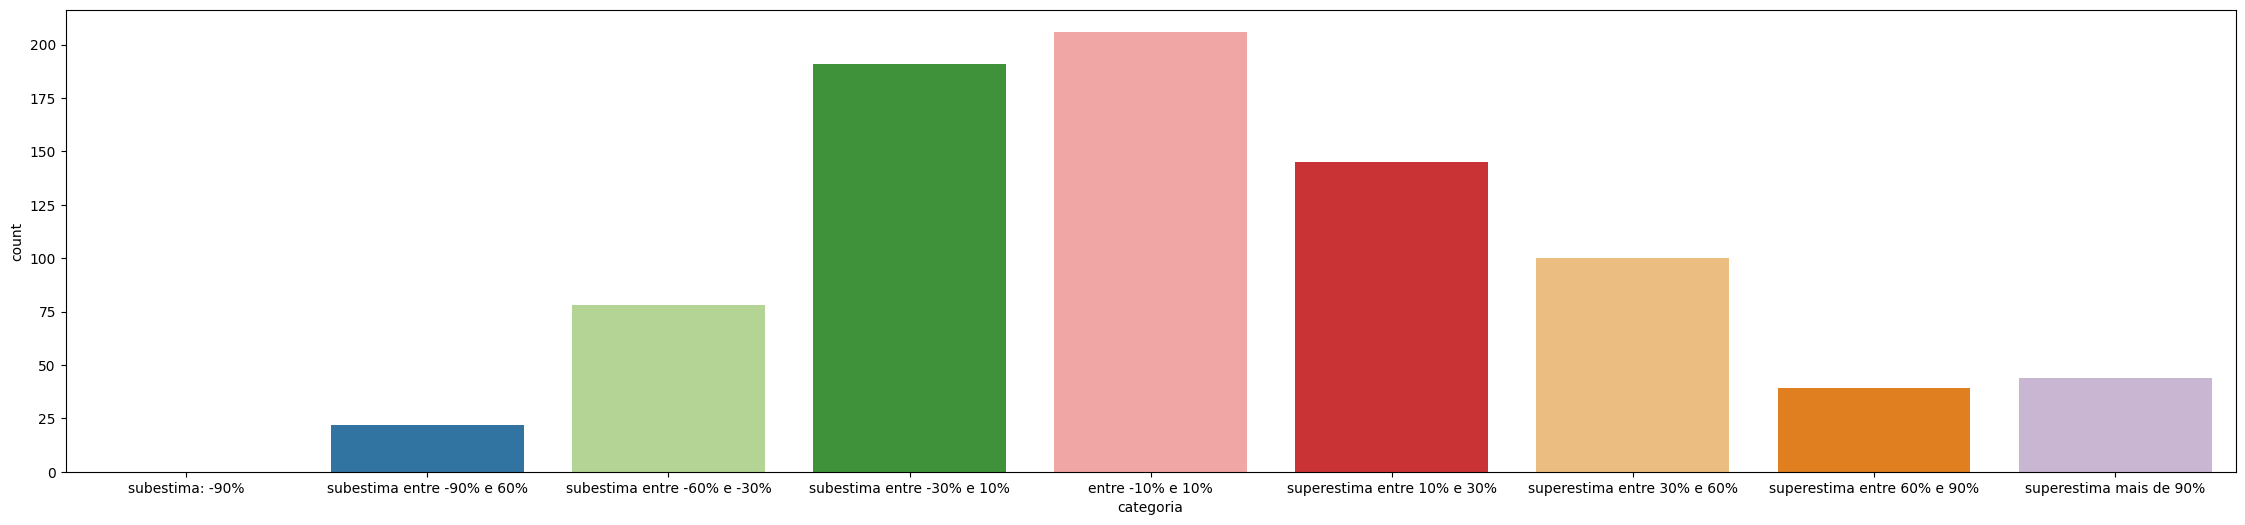

In [233]:
show_delta(np.array(y_test), y_pred.flatten())


In [235]:
x,y = load_data()

timestamp=3

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestamp)
x_test = split_sequences(x_test.values, timestamp)
y_train = y_train[:-timestamp+1]
y_test = y_test[:-timestamp+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

In [236]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 34123.32543129614
MAE: 22333.898095407196
MAPE: 0.2888356680754289


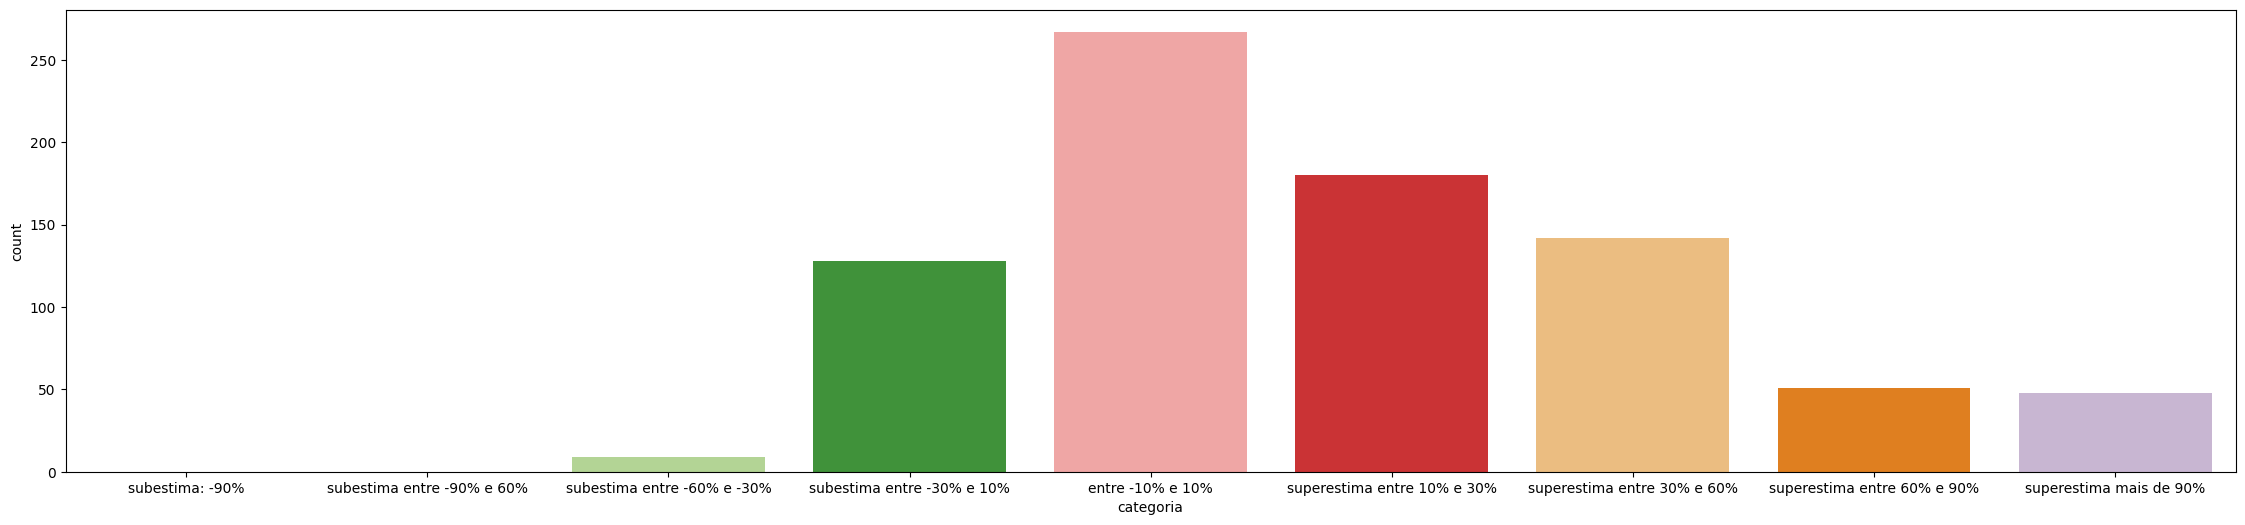

In [237]:
show_delta(np.array(y_test), y_pred.flatten())

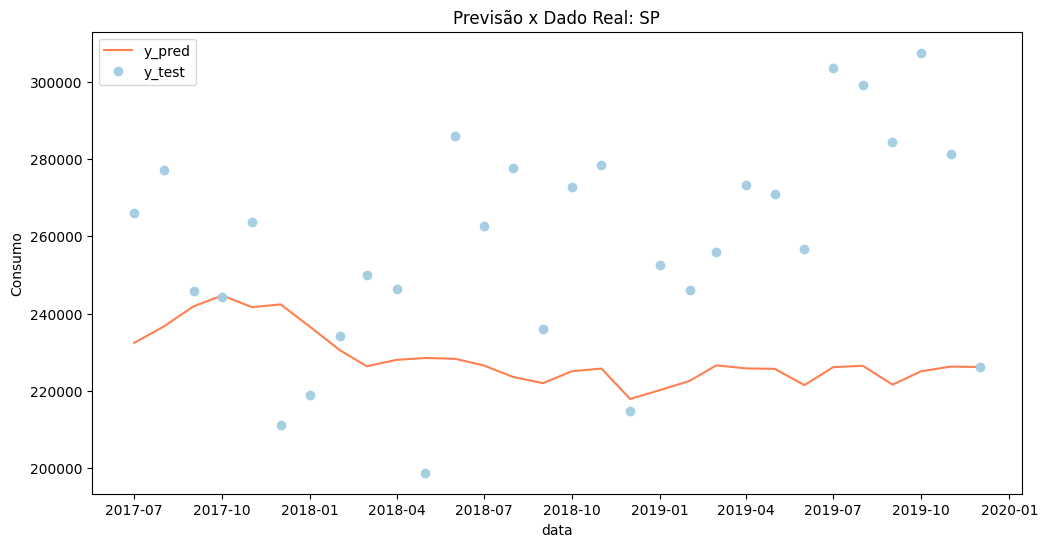

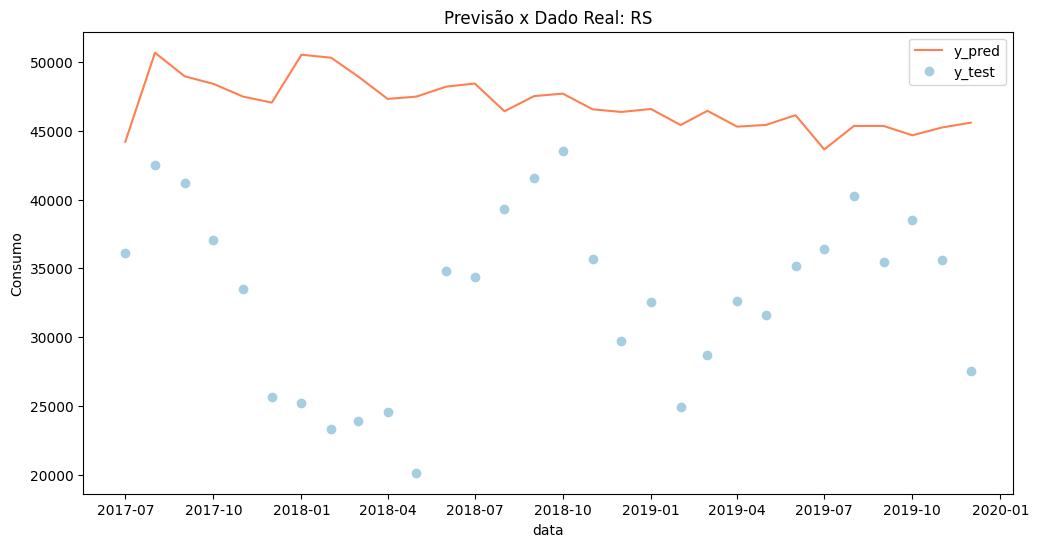

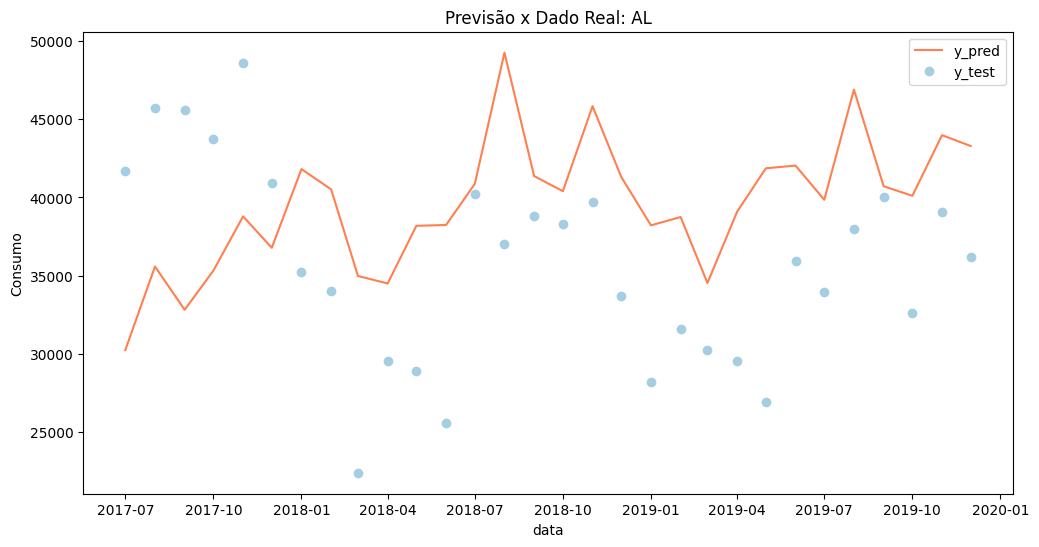

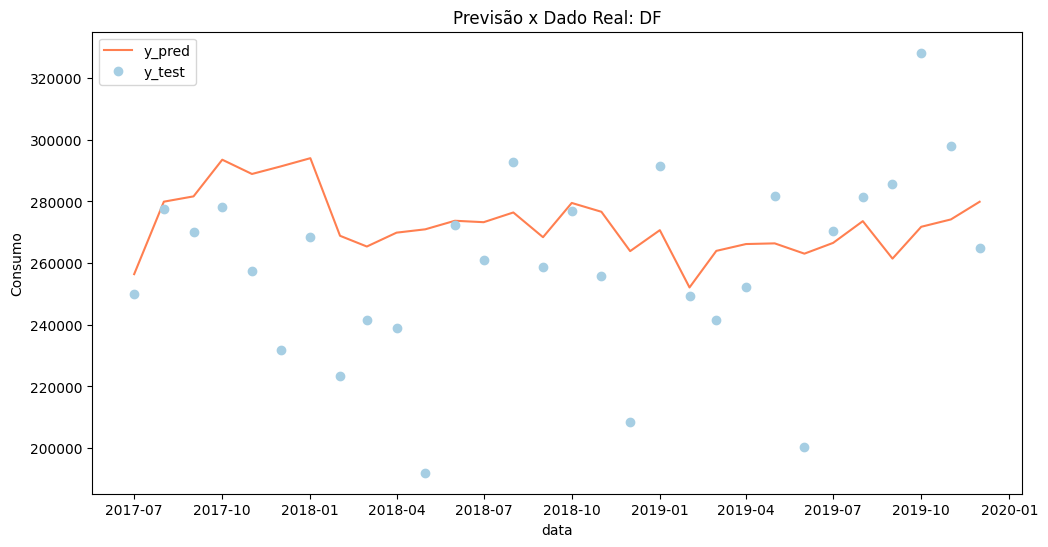

In [238]:
pred = get_pred(y_test, y_pred)
show_pred(pred, STATES)

In [246]:
x,y = load_data()

timestamp=5

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

x_train = split_sequences(x_train.values, timestamp)
x_test = split_sequences(x_test.values, timestamp)
y_train = y_train[:-timestamp+1]
y_test = y_test[:-timestamp+1]

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

In [247]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

26/26 [==============================] - 1s 8ms/step
Scores obtidos:
RMSE: 37553.252493419466
MAE: 22146.404637425956
MAPE: 0.23314900483087786


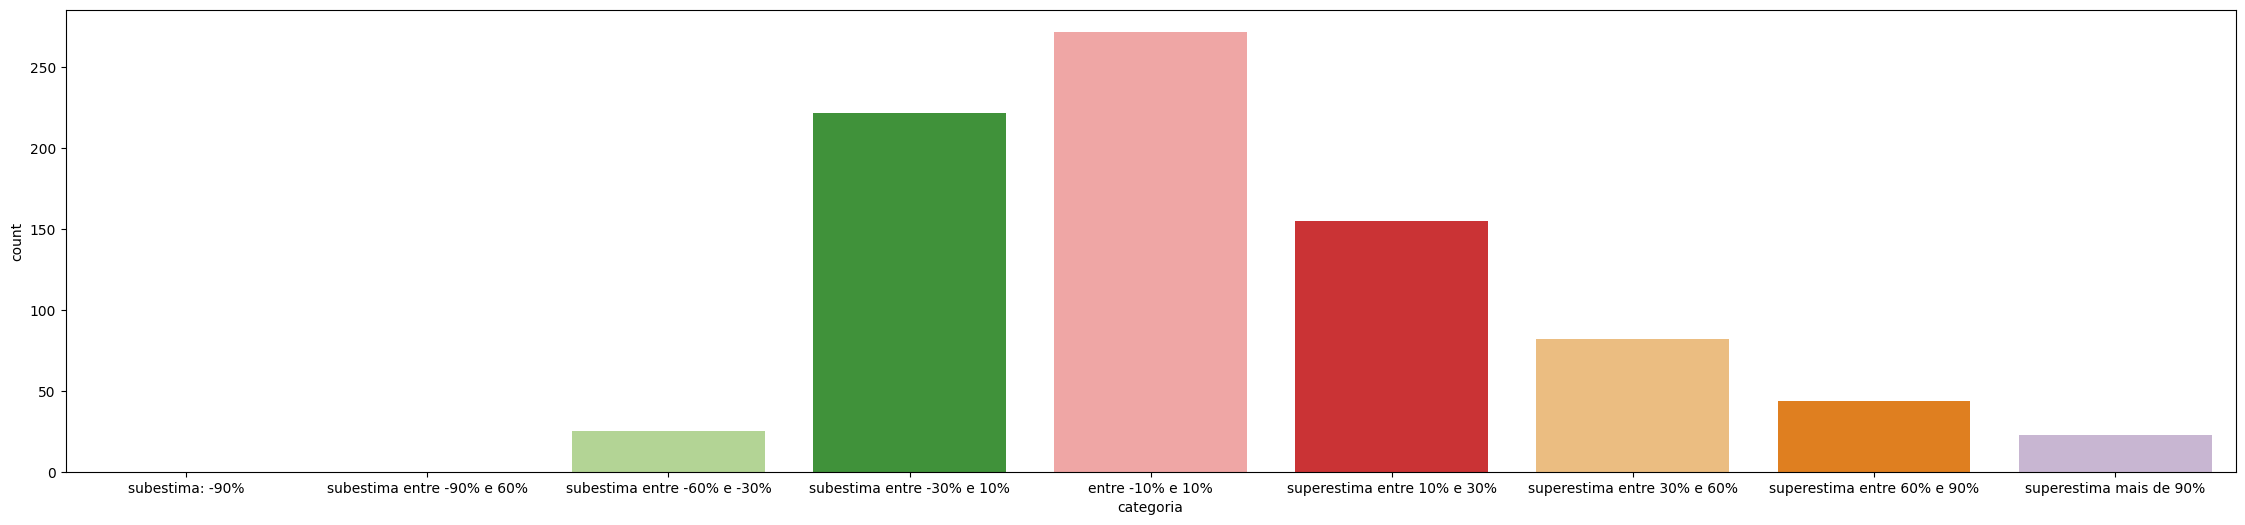

In [248]:
show_delta(np.array(y_test), y_pred.flatten())